# **Imbalanced Learning**
> **Imbalanced Datasets**: Distribution of instances of Data amongst the classes of your dataset is **Very skewed**

**Impacts of This**
- The Model shows a bias towards the majority class and does not generalize well to unseen data.
- Misleading Evaluation Metrics: ( *When the Model predicts the majority class, it gives high evaluation metrics, which could be foolish, if We give a Minority topic/unseen datapoint* )
- Rising False Negatives → Dangerous outcomes (Especially for medical purpose)

> **Biased Model**: The Model Trained on an Imbalanced dataset, and it may become biased towards the majority class.

___

# **Some Methods to Solve Class Imbalance**"
1. Resampling Techniques
2. SMOTE
3. Cost-Sensitive Learning
4. Ensemble Methods:
5. Data Augmenetation
6. Synthetic Data Generation

In [1]:
# Import Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline as ImbPipeline

# Imbalanced Learn Imports
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Set random seed for reproductability
np.random.seed(42)

# **Creating an Imbalanced Dataset**

In [3]:
# Create an Imbalanced Dataset
X, y = make_classification(
    n_samples = 10000,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class= 1,
    weights=[0.99],
    flip_y=0,
    random_state=1
)
print(f"Total samples: {len(y)}")
print(f"Class distribution: {Counter(y)}")
print(f"Class 0 (Majority): {sum(y == 0)} samples ({sum(y == 0)/len(y)*100:.2f}%)")
print(f"Class 1 (Minority): {sum(y == 1)} samples ({sum(y == 1)/len(y)*100:.2f}%)")
print(f"Imbalance ratio: {sum(y == 0)/sum(y == 1):.2f}:1")

Total samples: 10000
Class distribution: Counter({np.int64(0): 9900, np.int64(1): 100})
Class 0 (Majority): 9900 samples (99.00%)
Class 1 (Minority): 100 samples (1.00%)
Imbalance ratio: 99.00:1


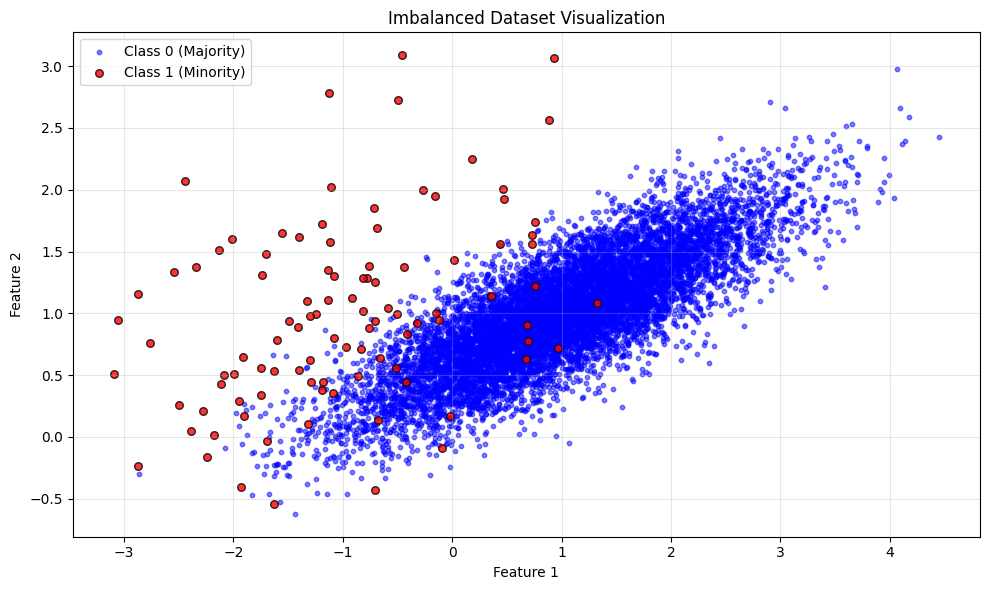

Notice how the minority class (red) is barely visible among the majority class (blue)!


In [5]:
# Visualize the Imbalanced Dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', alpha=0.5, label='Class 0 (Majority)', s=10)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', alpha=0.8, label='Class 1 (Minority)', s=30, edgecolors='black')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Imbalanced Dataset Visualization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice how the minority class (red) is barely visible among the majority class (blue)!")

# Baseline Classification with Decision Tree

In [8]:
# Baseline Decision Tree with Stratified K-Fold

# Initialize Baseline Classifier
dt_baseline = DecisionTreeClassifier(random_state=42)
# Create Stratified K-Fold Cross-Validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation and Calculate ROC-AUC Scores
baseline_scores = cross_val_score(
    dt_baseline,
    X, y, cv=skf, scoring='roc_auc',
    n_jobs=-1
)

print(f"ROC-AUC scores for each fold: {baseline_scores}")
print(f"Average ROC-AUC: {baseline_scores.mean():.4f} (+/- {baseline_scores.std():.4f})")

ROC-AUC scores for each fold: [0.77323232 0.79823232 0.74772727 0.74772727 0.8229798 ]
Average ROC-AUC: 0.7780 (+/- 0.0293)


# Pipeline with Resampling Techniques

## Random Over-Sampling & Random Under-sampling
**Random Over-Sampling**:
- Randomly Duplicates minority class samples
- Simple, but can lead to overfitting

**Random Under-Sampling**:
- Randomly removes majority class samples
- Can loose important information


In [10]:
# These concepts' combined pipeline (randomOUS)

randomOUS = ImbPipeline([
    ('over', RandomOverSampler(sampling_strategy=0.5, random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=0.8, random_state=43)),
    ('classifier', DecisionTreeClassifier(random_state=42))
    ])

scores_randomOUS = cross_val_score(randomOUS, X,y, cv=skf, scoring ='roc_auc', n_jobs=-1)
print(f"ROC-AUC scores: {scores_randomOUS}")
print(f"Average ROC-AUC: {scores_randomOUS.mean():.4f} (+/- {scores_randomOUS.std():.4f})")
print(f"Improvement over baseline: {(scores_randomOUS.mean() - baseline_scores.mean()):.4f}")

ROC-AUC scores: [0.79772727 0.77121212 0.79494949 0.7469697  0.82171717]
Average ROC-AUC: 0.7865 (+/- 0.0254)
Improvement over baseline: 0.0085


## SMOTE & Random Under-Sampling

**SMOTE (Synthetic Minority Over-sampling Technique)**
- Creates synthetic samples instead of duplicating
- Interpolates between existing minority Samples
- More Sophisticated than Random O'er Sampling
- Reduces Overfitting Risk

In [12]:
pipeline_smote_ROS = ImbPipeline([
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=0.8, random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

scores_smote_ROS = cross_val_score(pipeline_smote_ROS, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
print(f"ROC-AUC scores: {scores_smote_ROS}")
print(f"Average ROC-AUC: {scores_smote_ROS.mean():.4f} (+/- {scores_smote_ROS.std():.4f})")
print(f"Improvement over baseline: {(scores_smote_ROS.mean() - baseline_scores.mean()):.4f}")

ROC-AUC scores: [0.81287879 0.84166667 0.91540404 0.76792929 0.84166667]
Average ROC-AUC: 0.8359 (+/- 0.0480)
Improvement over baseline: 0.0579


## SMOTE & Tomek Links
**Tomek Links:**
- Identifies pairs of samples from different classes that are nearest neighbors
- Removes the majority sample between the pair
- Cleans the boundary between classes
- More Sophisticated than random-under-sampling

**SMOTETomek**
- Combines SMOTE(Over-Sampling) with Tomek-Links (cleaning)
- 1st Generates Synthetic Minority Sampels, then, removes noisy majority samples near the boundary

In [13]:
pipeline_SMOTETomek = ImbPipeline([
    ('smote_tomek', SMOTETomek(sampling_strategy=0.8, random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

scores_SMOTETomek = cross_val_score(
    pipeline_SMOTETomek,
    X,
    y,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1
)

print("\n=== 3c: SMOTE + Tomek Links ===")
print(f"ROC-AUC scores: {scores_SMOTETomek}")
print(f"Average ROC-AUC: {scores_SMOTETomek.mean():.4f} (+/- {scores_SMOTETomek.std():.4f})")
print(f"Improvement over baseline: {(scores_SMOTETomek.mean() - baseline_scores.mean()):.4f}")


=== 3c: SMOTE + Tomek Links ===
ROC-AUC scores: [0.80075758 0.7260101  0.8989899  0.74873737 0.8510101 ]
Average ROC-AUC: 0.8051 (+/- 0.0638)
Improvement over baseline: 0.0271


# Final Comparison of All Methods:


In [14]:
# Create comparison DataFrame
results = pd.DataFrame({
    'Method': [
        'Baseline (No Sampling)',
        'Random Over + Under',
        'SMOTE + Random Under',
        'SMOTE + Tomek Links'
    ],
    'Mean ROC-AUC': [
        baseline_scores.mean(),
        scores_randomOUS.mean(),
        scores_smote_ROS.mean(),
        scores_SMOTETomek.mean()
    ],
    'Std Dev': [
        baseline_scores.std(),
        scores_randomOUS.std(),
        scores_smote_ROS.std(),
        scores_SMOTETomek.std()
    ]
})

results['Improvement'] = results['Mean ROC-AUC'] - baseline_scores.mean()
results = results.sort_values('Mean ROC-AUC', ascending=False)

print("\n" + "="*80)
print("FINAL COMPARISON OF ALL METHODS")
print("="*80)
print(results.to_string(index=False))
print("="*80)


FINAL COMPARISON OF ALL METHODS
                Method  Mean ROC-AUC  Std Dev  Improvement
  SMOTE + Random Under      0.835909 0.048036     0.057929
   SMOTE + Tomek Links      0.805101 0.063834     0.027121
   Random Over + Under      0.786515 0.025432     0.008535
Baseline (No Sampling)      0.777980 0.029285     0.000000
